In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('data/full_case.csv', index_col=0)
def preprocess_data(df):
    for col in df.select_dtypes(include=["float"]).columns:
        df[col] = df[col] / 10e6
        df[col] = df[col] + abs(df[col].min()) + 1
        df[col] = np.log(df[col])
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

df = (df.pipe(preprocess_data))

In [3]:
X, default = df.iloc[:, 2:-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, default, stratify=default,test_size=0.33, random_state=42)

## Test random forest

In [4]:
clf = RandomForestClassifier(
    n_estimators = 1000,
    class_weight={0: 1, 1: 10},
    ccp_alpha = 0.001, 
    random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, class_weight={0: 1, 1: 10},
                       n_estimators=1000, n_jobs=-1, random_state=0)

              precision    recall  f1-score   support

  No default       0.99      0.76      0.86     33790
     Default       0.18      0.86      0.30      2084

    accuracy                           0.77     35874
   macro avg       0.58      0.81      0.58     35874
weighted avg       0.94      0.77      0.83     35874



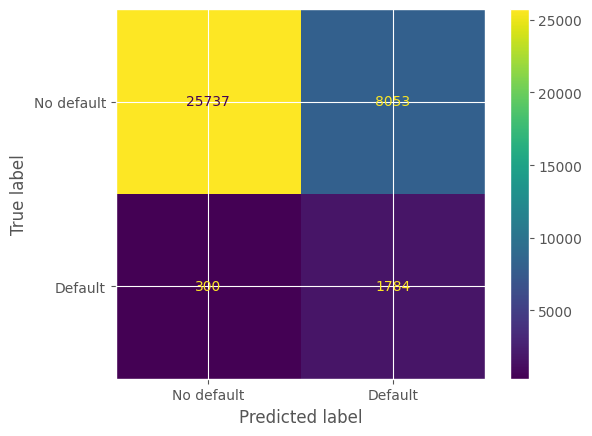

In [5]:
from sklearn.metrics import classification_report
y_p = clf.predict(X_test)

print(classification_report(y_test, y_p, target_names=['No default', 'Default']))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_p, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
disp.plot()
plt.show()

### RF feature importance

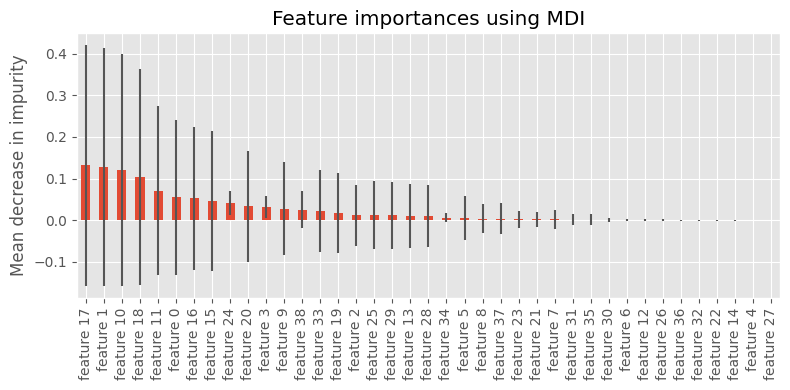

In [6]:

feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)#.sort_values(ascending=False)
sorted_idx = np.argsort(-forest_importances)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
forest_importances[sorted_idx].plot.bar(yerr=std[sorted_idx], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Test regresji logistycznej

In [9]:
#best_13_features = feature_names[sorted_idx.tolist()][:13]
X_best_subset = X.iloc[:, sorted_idx[:13]].copy()
default = df.iloc[:, -1]

              precision    recall  f1-score   support

  No default       0.98      0.80      0.88     33790
     Default       0.18      0.73      0.29      2084

    accuracy                           0.80     35874
   macro avg       0.58      0.76      0.59     35874
weighted avg       0.93      0.80      0.85     35874



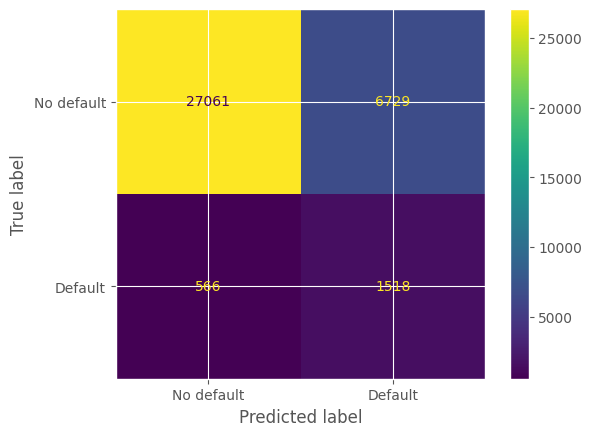

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_best_subset, default, stratify=default,test_size=0.33, random_state=42)


clf = LogisticRegression(
    max_iter=400,
    n_jobs=-1,
    class_weight={0: 1, 1: 10},
    random_state=0,
).fit(X_train, y_train)

y_p = clf.predict(X_test)

print(classification_report(y_test, y_p, target_names=['No default', 'Default']))

cm = confusion_matrix(y_test, y_p, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
disp.plot()
plt.show()